In [ ]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import classification_report


In [ ]:
df=pd.read_json("News Data.json",lines=True)
df.head(10)

,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/house-gop...,House GOP Faceplant On Ethics Coup Shows Publi...,POLITICS,"Public outrage blocked a secret, midnight effo...",Ryan Grim and Matt Fuller,2017-01-03
1,https://www.huffingtonpost.com/entry/patrick-m...,Rep. Patrick Murphy Comes Out In Favor Of Iran...,POLITICS,Many other Florida Democrats remain undecided.,Amanda Terkel,2015-08-31
2,https://www.huffingtonpost.com/entry/senators-...,Senators Strike Funding Deal To Help Flint Rep...,POLITICS,The measure was fast-tracked so a vote could c...,Laura Barrón-López,2016-02-24
3,https://www.huffingtonpost.com/entry/wednesday...,Wednesday's Morning Email: Stormy Daniels Suin...,POLITICS,A porn star is suing the president; let that s...,Eliot Nelson,2018-03-07
4,https://www.huffingtonpost.com/entry/lenore-an...,Crime Survivors Are Organizing. They Want Crim...,POLITICS,A troubled teen turned prosecutor is bringing ...,Nico Pitney,2016-08-31
5,https://www.huffingtonpost.com/entry/chinese-c...,Chinese Cyber-Attacks: Will the United States ...,POLITICS,"To avoid escalatory steps, the United States a...","Franz-Stefan Gady, ContributorSenior Fellow, E...",2014-05-27
6,https://www.huffingtonpost.com/entry/lewandows...,Donald Trump’s Top Staff Make Big Bucks But Do...,POLITICS,"Corey Lewandowski has made $541,000 from the c...",S.V. Date,2016-10-21
7,https://www.huffingtonpost.com/entry/pat-rober...,A GOP Senator Told A Democrat To Lighten Up Du...,POLITICS,Other members of his committee were not having...,Sam Levine,2017-01-19
8,https://www.huffpost.com/entry/rep-kevin-mccar...,Rep. Kevin McCarthy Deletes Tweet Singling Out...,POLITICS,The Republican leader warned that the wealthy ...,Mary Papenfuss,2018-10-28
9,https://www.huffingtonpost.com/entry/supreme-c...,Supreme Court To Hear Dispute Over California ...,POLITICS,The “crisis pregnancy centers” counsel women n...,"Lawrence Hurley, Reuters",2017-11-13


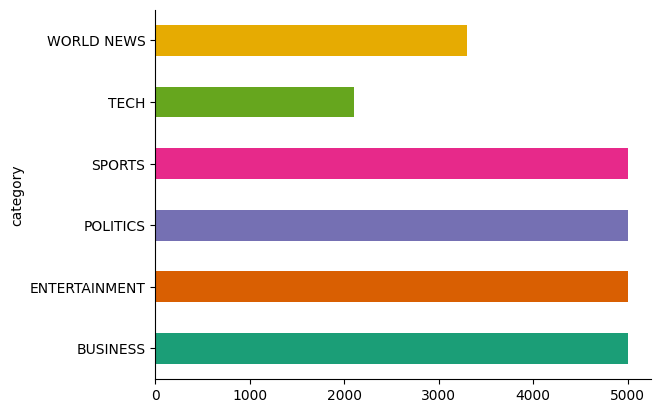

In [ ]:
# @title category

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Load the stopwords and initialize the stemmer and lemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and stem or lemmatize the words
    words = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # words = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join the words back into a string
    processed_text = ' '.join(words)
    return processed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Preprocess the 'headline' column
df['headline'] = df['headline'].apply(preprocess_text)

# Preprocess the 'short_description' column
df['short_description'] = df['short_description'].apply(preprocess_text)

In [ ]:
top_categories = ['POLITICS', 'WORLD NEWS', 'ENTERTAINMENT', 'SPORTS', 'BUSINESS', 'TECH']

# Filter out rows with categories not in the top 6
df = df[df['category'].isin(top_categories)]


In [ ]:
df.shape

(25403, 6)

In [ ]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['headline'] + ' ' + df['short_description'], df['category'], test_size=0.3, random_state=1)

# Tokenize the train and test texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)


In [ ]:
# Convert the labels to numerical values
labels_map = {label: i for i, label in enumerate(train_labels.unique())}
train_labels = [labels_map[label] for label in train_labels.tolist()]
test_labels = [labels_map[label] for label in test_labels.tolist()]

# Convert the train and test data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_labels))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']),
                                              torch.tensor(test_labels))

# Load the pre-trained BERT model and modify the last layer for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_map))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Get the input_ids, attention_mask, and labels from your dataset
# Assuming you want to move a batch of data to the device
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)

# Get a batch of data
input_ids, attention_mask, labels = next(iter(train_dataloader))

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

In [ ]:
import torch

# Assuming `train_dataset`, `model`, and necessary imports are already defined

# DataLoader for training dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Set device for model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Optimizer
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Number of epochs
epochs = 5

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(train_loader)  # Number of batches in the epoch

    for batch_idx, batch in enumerate(train_loader):
        optim.zero_grad()  # Zero the gradients
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]

        # Backward pass and optimization
        loss.backward()
        optim.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Print progress every 10 batches (adjust as needed)
        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{num_batches}], Loss: {loss.item():.4f}')

    # Print average loss for the epoch
    avg_epoch_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch + 1}/{epochs}] completed. Average Loss: {avg_epoch_loss:.4f}')


Epoch [1/5], Batch [10/1271], Loss: 1.7954
Epoch [1/5], Batch [20/1271], Loss: 1.7410
Epoch [1/5], Batch [30/1271], Loss: 1.5034
Epoch [1/5], Batch [40/1271], Loss: 1.3013
Epoch [1/5], Batch [50/1271], Loss: 1.1070
Epoch [1/5], Batch [60/1271], Loss: 1.4066
Epoch [1/5], Batch [70/1271], Loss: 1.1580
Epoch [1/5], Batch [80/1271], Loss: 0.7662
Epoch [1/5], Batch [90/1271], Loss: 0.7668
Epoch [1/5], Batch [100/1271], Loss: 0.6214
Epoch [1/5], Batch [110/1271], Loss: 0.8271
Epoch [1/5], Batch [120/1271], Loss: 0.7836
Epoch [1/5], Batch [130/1271], Loss: 0.6712
Epoch [1/5], Batch [140/1271], Loss: 0.4897
Epoch [1/5], Batch [150/1271], Loss: 0.6824
Epoch [1/5], Batch [160/1271], Loss: 0.6519
Epoch [1/5], Batch [170/1271], Loss: 0.5734
Epoch [1/5], Batch [180/1271], Loss: 0.4818
Epoch [1/5], Batch [190/1271], Loss: 0.6122
Epoch [1/5], Batch [200/1271], Loss: 0.5601
Epoch [1/5], Batch [210/1271], Loss: 1.0021
Epoch [1/5], Batch [220/1271], Loss: 0.5693
Epoch [1/5], Batch [230/1271], Loss: 0.99

In [ ]:
# Evaluate the model on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs[0], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print('Test Accuracy: {:.2f}'.format(accuracy))

Test Accuracy: 0.84


In [ ]:
# Get the predictions for the test set
model.eval()
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs[0], 1)
        y_pred.extend(predicted.cpu().numpy())

# Get the actual labels for the test set
y_true = test_labels

# Print the classification report
target_names = list(labels_map.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

ENTERTAINMENT       0.85      0.89      0.87       974
         TECH       0.79      0.67      0.73       418
   WORLD NEWS       0.83      0.85      0.84       667
     POLITICS       0.79      0.81      0.80      1022
     BUSINESS       0.80      0.83      0.81       990
       SPORTS       0.92      0.86      0.89      1010

     accuracy                           0.84      5081
    macro avg       0.83      0.82      0.82      5081
 weighted avg       0.84      0.84      0.83      5081



In [ ]:
def predict_category(article_text):
    # preprocess the article text
    preprocessed_text = preprocess_text(article_text)

    # tokenize the text
    input_ids = tokenizer.encode(preprocessed_text, truncation=True, padding=True, return_tensors='pt')

    # make a prediction
    with torch.no_grad():
        outputs = model(input_ids.to(device), attention_mask=None)
        _, predicted = torch.max(outputs[0], 1)

    # get the predicted category label
    label_map = {v: k for k, v in labels_map.items()}
    predicted_label = label_map[predicted.item()]

    return predicted_label

In [ ]:
article = "Apple unveils new iPhone"
predicted_category = predict_category(article)
print(predicted_category)


TECH


In [ ]:
article = "The impact of 5G technology on connectivity and the Internet of Things (IoT)."
predicted_category = predict_category(article)
print(predicted_category)


WORLD NEWS


In [ ]:
article = "The latest superhero film, 'Cosmic Avenger,' has become a massive hit, captivating audiences with its thrilling action scenes and special effects. Directed by Emma Roberts, the film features a stellar cast and has received praise for its engaging storyline and innovative visual effects"
predicted_category = predict_category(article)
print(predicted_category)


ENTERTAINMENT


In [ ]:
import os

# Directory to save the model
save_directory = "./bert_model"

# Create the directory if it does not exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the model
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('./bert_model/tokenizer_config.json',
 './bert_model/special_tokens_map.json',
 './bert_model/vocab.txt',
 './bert_model/added_tokens.json')

In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in your Google Drive where you want to save the model
drive_path = '/content/drive/My Drive/bert_model'

# Copy the model directory to Google Drive
shutil.copytree(save_directory, drive_path)

print(f"Model saved to {drive_path}")

Mounted at /content/drive
Model saved to /content/drive/My Drive/bert_model


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW

# Load the pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_map))
model.to(device)

# Prepare DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}')

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_bert')
tokenizer.save_pretrained('./fine_tuned_bert')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/3], Loss: 0.6810
Epoch [2/3], Loss: 0.3867
Epoch [3/3], Loss: 0.2425


('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json')

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained('./fine_tuned_bert')
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_bert')

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained('./fine_tuned_bert')
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_bert')

def predict_category(article_text):
    model.eval()
    input_ids = tokenizer.encode(article_text, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        _, predicted = torch.max(outputs.logits, 1)
    return labels_map_inverse[predicted.item()]


In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Define the directory where you want to save the model
drive_path = '/content/drive/MyDrive/bert_fine_tuned'

# Load your fine-tuned model and tokenizer (assuming they are already fine-tuned and ready)
model = BertForSequenceClassification.from_pretrained('./fine_tuned_bert')
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_bert')

# Save the model and tokenizer
model.save_pretrained(drive_path)
tokenizer.save_pretrained(drive_path)

print(f"Model and tokenizer saved to {drive_path}")


Model and tokenizer saved to /content/drive/MyDrive/bert_fine_tuned


In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Prepare DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained('./fine_tuned_bert')
model.to(device)
model.eval()

# Lists to store true labels and predictions
true_labels = []
predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy:.2f}')


Test Accuracy: 0.85


In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

# Prepare DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained('./fine_tuned_bert')
model.to(device)
model.eval()

# Lists to store true labels and predictions
true_labels = []
predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Generate the classification report
target_names = list(labels_map.keys())  # Assuming labels_map is your dictionary for label names
report = classification_report(true_labels, predictions, target_names=target_names)

print(report)


               precision    recall  f1-score   support

ENTERTAINMENT       0.90      0.84      0.87      1480
       SPORTS       0.90      0.91      0.91      1485
     BUSINESS       0.81      0.80      0.81      1493
     POLITICS       0.81      0.85      0.83      1536
   WORLD NEWS       0.88      0.85      0.86       991
         TECH       0.74      0.82      0.78       636

     accuracy                           0.85      7621
    macro avg       0.84      0.84      0.84      7621
 weighted avg       0.85      0.85      0.85      7621

